## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/pasta')  # Cache generated in "Anchors" notebook
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 23.1,
 5: 24.5,
 10: 25.2,
 20: 26.1,
 30: 27.0,
 40: 28.6,
 50: 30.4,
 60: 32.2,
 70: 34.1,
 80: 36.4,
 90: 39.9,
 95: 42.7,
 99: 48.3}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 8.0,
 5: 8.1,
 10: 8.2,
 20: 8.3,
 30: 8.4,
 40: 8.5,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.39, sd=0.42)
   - 0.1 weight on <Distribution> lognorm(mean=2.25, sd=0.7)},
 'infra': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.04, sd=0.63)
   - 0.1 weight on <Distribution> lognorm(mean=1.7, sd=0.37)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.9 weight on <Distribution> lognorm(mean=1.04, sd=0.63)
   - 0.1 weight on <Distribution> lognorm(mean=1.7, sd=0.37)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - 0.85 weight on <Distribution> lognorm(mean=1.7, sd=0.37)


In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': sq.lognorm(3, 15),
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(1.5, 3.5),     # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 23),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1, 4.5, lclip=0.9),
             '2025_spend_doubling_time': sq.norm(0.95, 1.03, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples, digits=5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 971848.56it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00032,
 50: 0.00041,
 60: 0.00053,
 70: 0.0007,
 80: 0.00109,
 90: 0.00215,
 95: 0.00384,
 99: 0.00966}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.3e+09',
 50: '9.3e+09',
 60: '1.2e+10',
 70: '1.6e+10',
 80: '2.5e+10',
 90: '4.9e+10',
 95: '8.8e+10',
 99: '2.2e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 40.0 log FLOP (~10 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 20.8 log FLOP (~626 quintillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~199 million). This doubles every 2.4 years to a max of 0.208402% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.6 max log FLOP (394 septillion) available - TAI takes 40.0 log FLOP (10 million decillion) - log $ 21.7 to buy TAI (5 sextillion) vs. willingness to pay log $ 8.3 (198 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.6)
Year: 2024 - 26.8 max log FLOP (677 septillion) available - TAI takes 39.7 log FLOP (5 million decillion) - log $ 21.3 to buy TAI (2 sextillion) vs. willingness to pay log $ 8.4 (265 million) - 18.4 log FLOP per $ (3 quintilli

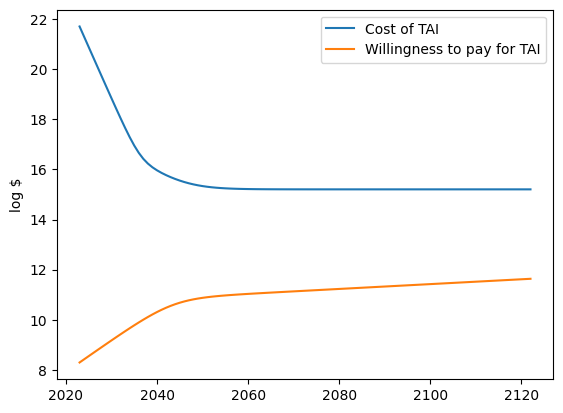

-
-
## SAMPLE RUN 2 ##
It takes 26.0 log FLOP (~100 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.0 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~461 million). This doubles every 4.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.9 max log FLOP (851 septillion) available - TAI takes 26.0 log FLOP (100 septillion) - log $ 7.7 to buy TAI (50 million) vs. willingness to pay log $ 8.6 (427 million) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 26.9)
-- algorithms p_nonscaling_issue p=0.85 -> Nonscaling delay occured
-- -- this delay is 4 years (total delay 4 years)
-- infra p_nonscaling_issue p=0.9 -> Nonscaling delay occured
-- -- this delay is 8 years (total delay 10 years)
-- data p_nonsc

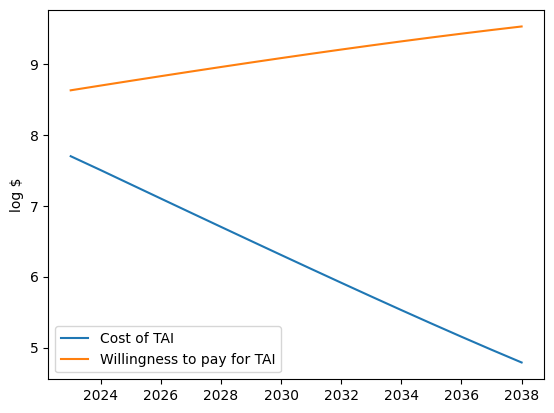

-
-
## SAMPLE RUN 3 ##
It takes 31.4 log FLOP (~25 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 1.4 years to a max of 0.025021% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.4 max log FLOP (3 octillion) available - TAI takes 31.4 log FLOP (25 nonillion) - log $ 13.1 to buy TAI (13 trillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.3 log FLOP per $ (2 quintillion) (Effective 2023-logFLOP: 27.4)
Year: 2024 - 27.7 max log FLOP (5 octillion) available - TAI takes 31.3 log FLOP (19 nonillion) - log $ 12.9 to buy TAI (8 trillion) vs. willingness to pay log $ 9.3 (2 billion) - 18.4 log FLOP per $ (3 quintillion) (Effective 2023-logFLOP: 27.8)
Year

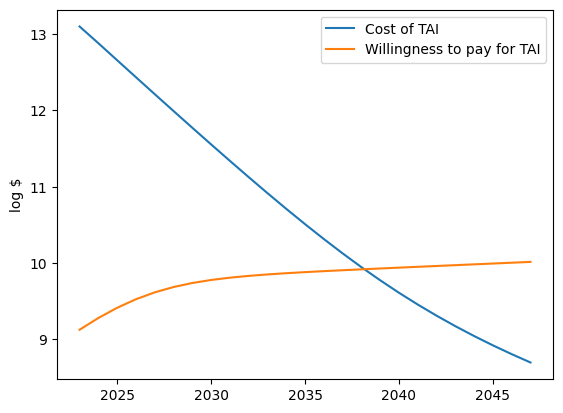

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.59it/s]


Shuffling data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 231.31it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2032',
 '10%: 2034',
 '15%: 2036',
 '20%: 2037',
 '25%: 2038',
 '35%: 2041',
 '50%: 2047',
 '60%: 2053',
 '75%: 2073',
 '80%: 2109',
 '90%: >2123',
 '95%: >2123']
(Mean: 2062)
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 9 years from now',
 '10%: 11 years from now',
 '15%: 13 years from now',
 '20%: 14 years from now',
 '25%: 15 years from now',
 '35%: 18 years from now',
 '50%: 24 years from now',
 '60%: 30 years from now',
 '75%: 50 years from now',
 '80%: 86 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
(Mean: 39 years from now)
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.0%
2028-2029: 1.3%
2030-2034: 10.1%
2035-2039: 17.5%
2040-2049: 26.1%
2050-2059: 12.2%
2060-2069: 6.7%
2070-2079: 2.8%
2080-2089: 1.6%
2090-2099: 0.9%
2100-2109: 0.

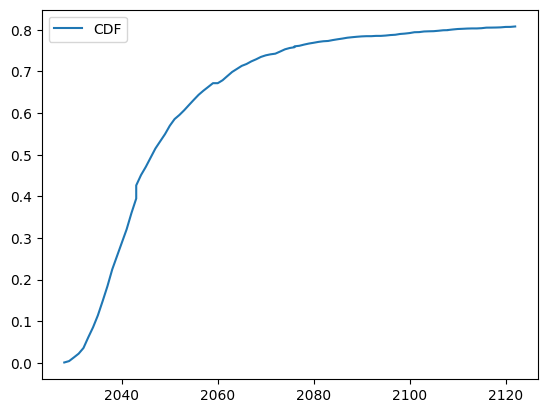

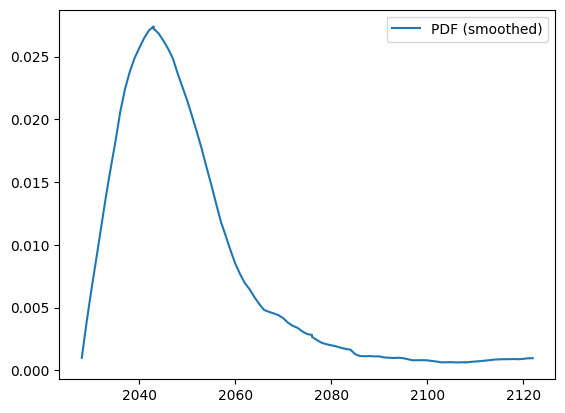

-
-
## TAI FLOP SIZE ##
{1: 23.6,
 5: 24.6,
 10: 25.4,
 20: 26.2,
 30: 27.3,
 40: 29.1,
 50: 30.8,
 60: 32.4,
 70: 34.3,
 80: 36.3,
 90: 39.5,
 95: 42.2,
 99: 48.9}
(Mean: 31.7)


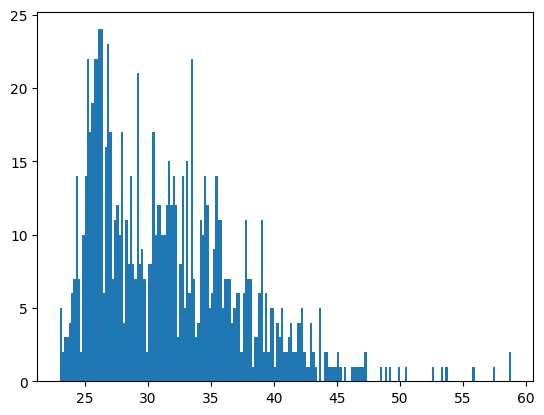

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION ##
{1: 20.0,
 5: 14.7,
 10: 12.5,
 20: 10.2,
 30: 8.6,
 40: 7.4,
 50: 6.6,
 60: 5.8,
 70: 5.2,
 80: 4.4,
 90: 3.7,
 95: 3.1,
 99: 2.3}
(Mean: 7.5)


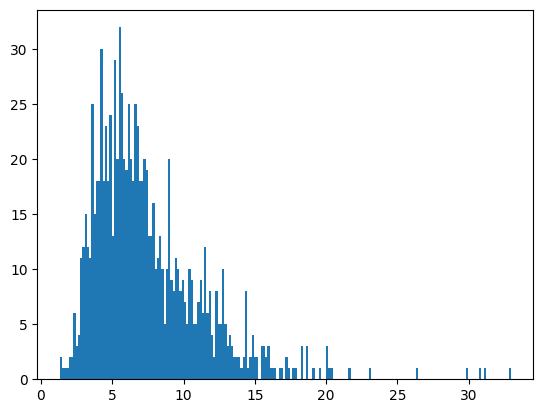

-
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.9,
 5: 3.5,
 10: 3.3,
 20: 3.0,
 30: 2.8,
 40: 2.7,
 50: 2.5,
 60: 2.4,
 70: 2.2,
 80: 2.0,
 90: 1.8,
 95: 1.6,
 99: 1.2}
(Mean: 2.5)


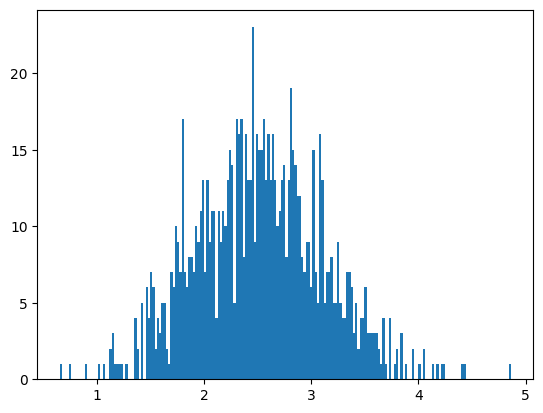

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.6,
 5: 21.1,
 10: 21.2,
 20: 21.5,
 30: 21.7,
 40: 21.9,
 50: 22.0,
 60: 22.2,
 70: 22.3,
 80: 22.5,
 90: 22.8,
 95: 23.1,
 99: 23.5}
(Mean: 22.0)


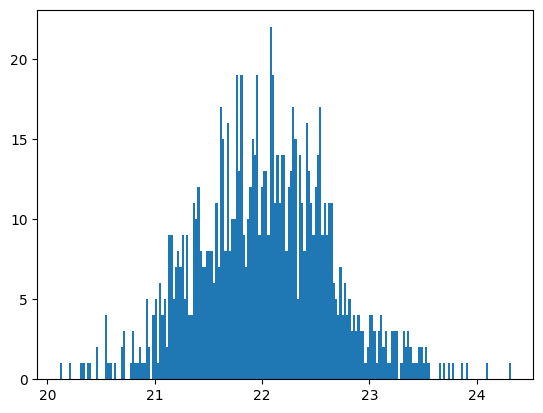

-
-
## INITIAL PAY ##
{1: 8.0,
 5: 8.1,
 10: 8.2,
 20: 8.3,
 30: 8.4,
 40: 8.5,
 50: 8.6,
 60: 8.7,
 70: 8.8,
 80: 8.9,
 90: 9.1,
 95: 9.3,
 99: 9.7}
(Mean: 8.6)


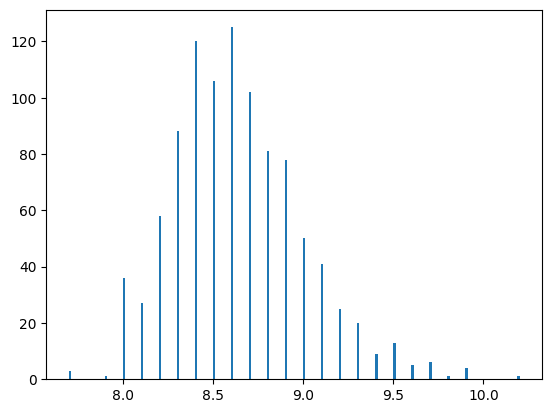

-
-
## GDP GROWTH ##
{1: 1.0,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.04,
 99: 1.04}
(Mean: 1.0)


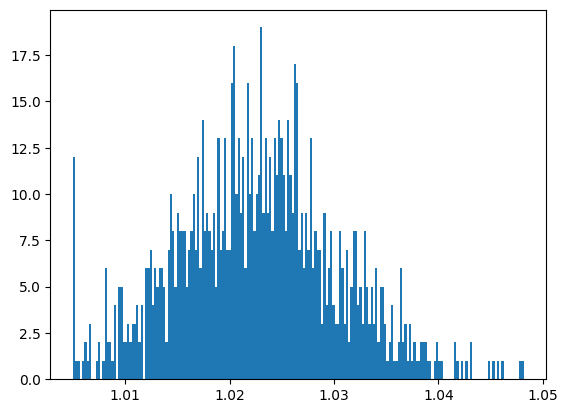

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00031,
 50: 0.0004,
 60: 0.00051,
 70: 0.00067,
 80: 0.00105,
 90: 0.00221,
 95: 0.00429,
 99: 0.00965}
(Mean: 0.0)


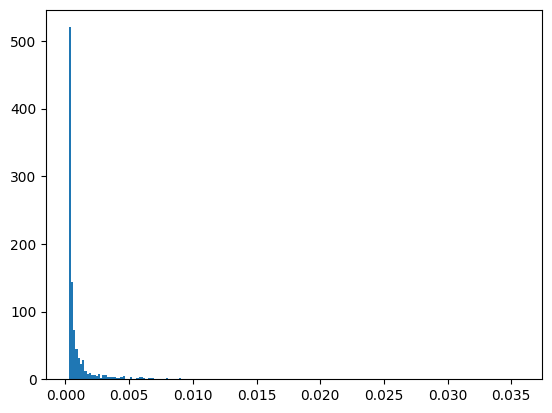

-
-
## SPEND DOUBLING TIME ##
{1: 5.2,
 5: 4.5,
 10: 4.2,
 20: 3.6,
 30: 3.3,
 40: 2.9,
 50: 2.7,
 60: 2.4,
 70: 2.1,
 80: 1.8,
 90: 1.3,
 95: 0.9,
 99: 0.9}
(Mean: 2.7)


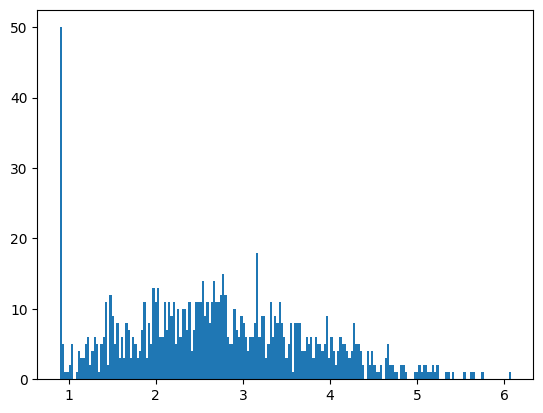

-
-
-
-
## GDP Over Time ##


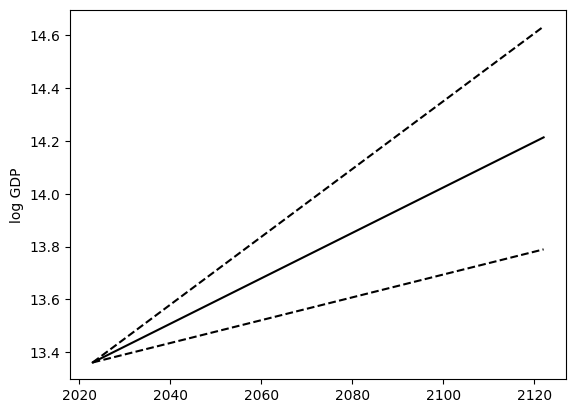

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

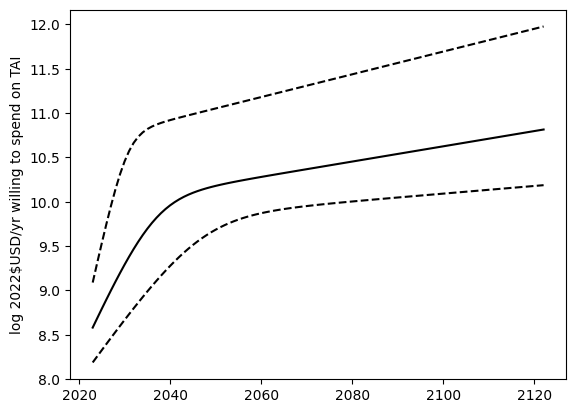

Year: 2023 - willingness log 2022$USD per year 8.6 (~382 million) 90% CI 8.2 (~154 million) - 9.1 (~1 billion)
Year: 2024 - willingness log 2022$USD per year 8.7 (~488 million) 90% CI 8.3 (~181 million) - 9.3 (~2 billion)
Year: 2025 - willingness log 2022$USD per year 8.8 (~622 million) 90% CI 8.3 (~212 million) - 9.5 (~3 billion)
Year: 2026 - willingness log 2022$USD per year 8.9 (~790 million) 90% CI 8.4 (~249 million) - 9.7 (~6 billion)
Year: 2027 - willingness log 2022$USD per year 9.0 (~1 billion) 90% CI 8.5 (~292 million) - 10.0 (~9 billion)
Year: 2028 - willingness log 2022$USD per year 9.1 (~1 billion) 90% CI 8.5 (~341 million) - 10.1 (~14 billion)
Year: 2029 - willingness log 2022$USD per year 9.2 (~2 billion) 90% CI 8.6 (~399 million) - 10.3 (~20 billion)
Year: 2030 - willingness log 2022$USD per year 9.3 (~2 billion) 90% CI 8.7 (~465 million) - 10.5 (~29 billion)
Year: 2031 - willingness log 2022$USD per year 9.4 (~2 billion) 90% CI 8.7 (~542 million) - 10.6 (~37 billion)
Ye

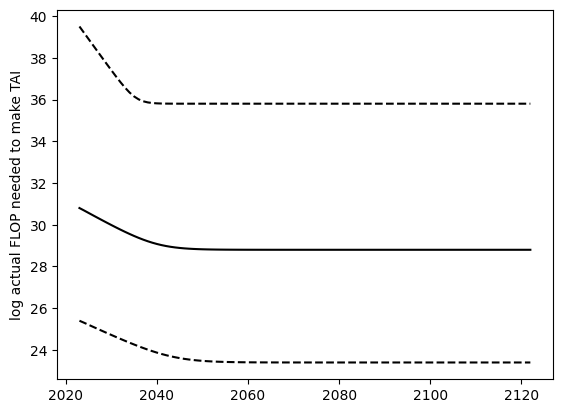

Year: 2023 - log FLOP needed for TAI 30.8 (~6 nonillion) 90% CI 25.4 (~25 septillion) - 39.5 (~3 million decillion)
Year: 2024 - log FLOP needed for TAI 30.7 (~5 nonillion) 90% CI 25.3 (~20 septillion) - 39.2 (~2 million decillion)
Year: 2025 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% CI 25.2 (~16 septillion) - 38.9 (~791 thousand decillion)
Year: 2026 - log FLOP needed for TAI 30.4 (~3 nonillion) 90% CI 25.1 (~13 septillion) - 38.6 (~396 thousand decillion)
Year: 2027 - log FLOP needed for TAI 30.3 (~2 nonillion) 90% CI 25.0 (~10 septillion) - 38.3 (~198 thousand decillion)
Year: 2028 - log FLOP needed for TAI 30.2 (~2 nonillion) 90% CI 24.9 (~8 septillion) - 38.0 (~99 thousand decillion)
Year: 2029 - log FLOP needed for TAI 30.1 (~1 nonillion) 90% CI 24.8 (~7 septillion) - 37.7 (~50 thousand decillion)
Year: 2030 - log FLOP needed for TAI 30.0 (~969 octillion) 90% CI 24.7 (~5 septillion) - 37.4 (~25 thousand decillion)
Year: 2031 - log FLOP needed for TAI 29.9 (~750 octillion)

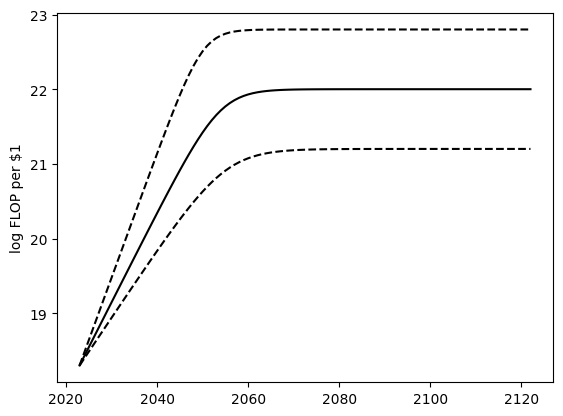

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~2 quintillion) - 18.5 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.6 (~4 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.8 (~6 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 19.0 (~9 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~6 quintillion) - 19.1 (~14 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.8 (~7 quintillion) - 19.3 (~20 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 18.9 (~9 quintillion) - 19.5 (~30 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.0 (~11 quintillion) - 19.6 (~43 quinti

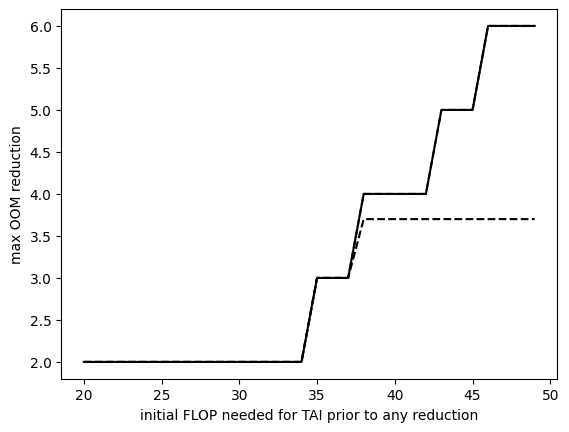

TAI log FLOP 20 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 21 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 22 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 23 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 24 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 25 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 26 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 27 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 28 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 29 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 30 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 31 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 32 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> 2.0 OOM reductions possible (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> 2.0 OOM reductions possible (

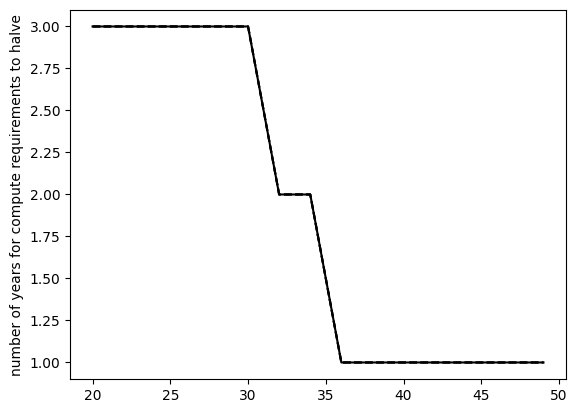

TAI log FLOP 20 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 21 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 22 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 23 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 24 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 25 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 26 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 27 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 28 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 29 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 30 -> algo doubling rate 3.0yrs (90% CI: 3.0 to 3.0)
TAI log FLOP 31 -> algo doubling rate 2.5yrs (90% CI: 2.5 to 2.5)
TAI log FLOP 32 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 33 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FLOP 34 -> algo doubling rate 2.0yrs (90% CI: 2.0 to 2.0)
TAI log FL

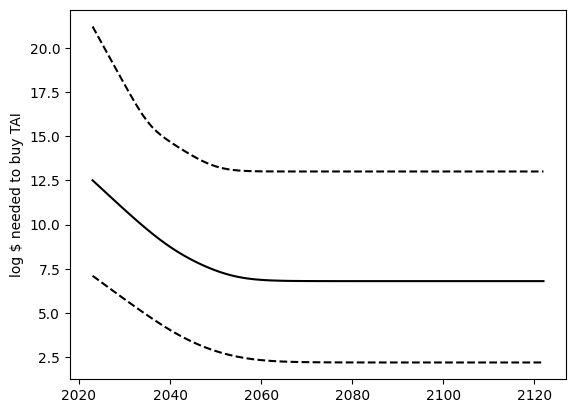

Year: 2023 - 12.5 log 2022$USD to buy TAI (~3 trillion) 90% CI 7.1 (~13 million) - 21.2 (~2 sextillion)
Year: 2024 - 12.3 log 2022$USD to buy TAI (~2 trillion) 90% CI 6.9 (~8 million) - 20.7 (~539 quintillion)
Year: 2025 - 12.0 log 2022$USD to buy TAI (~1 trillion) 90% CI 6.7 (~5 million) - 20.3 (~184 quintillion)
Year: 2026 - 11.8 log 2022$USD to buy TAI (~613 billion) 90% CI 6.5 (~3 million) - 19.8 (~63 quintillion)
Year: 2027 - 11.5 log 2022$USD to buy TAI (~355 billion) 90% CI 6.3 (~2 million) - 19.3 (~21 quintillion)
Year: 2028 - 11.3 log 2022$USD to buy TAI (~206 billion) 90% CI 6.2 (~1 million) - 18.9 (~7 quintillion)
Year: 2029 - 11.1 log 2022$USD to buy TAI (~120 billion) 90% CI 6.0 (~932 thousand) - 18.4 (~2 quintillion)
Year: 2030 - 10.8 log 2022$USD to buy TAI (~70 billion) 90% CI 5.8 (~606 thousand) - 17.9 (~858 quadrillion)
Year: 2031 - 10.6 log 2022$USD to buy TAI (~41 billion) 90% CI 5.6 (~395 thousand) - 17.5 (~299 quadrillion)
Year: 2032 - 10.4 log 2022$USD to buy TAI

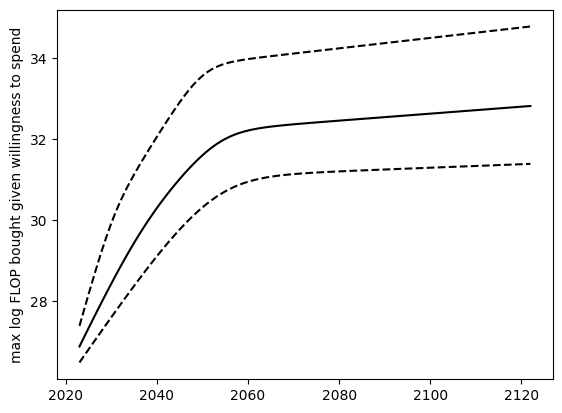

Year: 2023 - max log FLOP 26.9 (~761 septillion) 90% CI 26.5 (~307 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log FLOP 27.1 (~1 octillion) 90% CI 26.6 (~445 septillion) - 27.8 (~6 octillion)
Year: 2025 - max log FLOP 27.3 (~2 octillion) 90% CI 26.8 (~644 septillion) - 28.2 (~15 octillion)
Year: 2026 - max log FLOP 27.6 (~4 octillion) 90% CI 27.0 (~931 septillion) - 28.6 (~35 octillion)
Year: 2027 - max log FLOP 27.8 (~6 octillion) 90% CI 27.1 (~1 octillion) - 28.9 (~83 octillion)
Year: 2028 - max log FLOP 28.0 (~10 octillion) 90% CI 27.3 (~2 octillion) - 29.3 (~189 octillion)
Year: 2029 - max log FLOP 28.2 (~17 octillion) 90% CI 27.4 (~3 octillion) - 29.6 (~411 octillion)
Year: 2030 - max log FLOP 28.4 (~27 octillion) 90% CI 27.6 (~4 octillion) - 29.9 (~844 octillion)
Year: 2031 - max log FLOP 28.6 (~44 octillion) 90% CI 27.8 (~6 octillion) - 30.2 (~2 nonillion)
Year: 2032 - max log FLOP 28.9 (~71 octillion) 90% CI 27.9 (~8 octillion) - 30.5 (~3 nonillion)
Year: 2033 - max log 

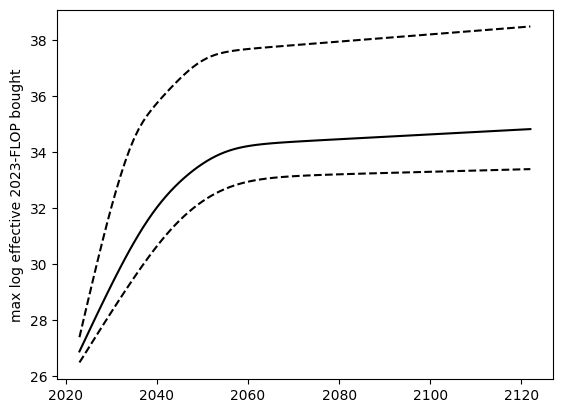

Year: 2023 - max log effective 2023-FLOP 26.9 (~761 septillion) 90% CI 26.5 (~307 septillion) - 27.4 (~2 octillion)
Year: 2024 - max log effective 2023-FLOP 27.2 (~2 octillion) 90% CI 26.7 (~554 septillion) - 28.1 (~12 octillion)
Year: 2025 - max log effective 2023-FLOP 27.6 (~4 octillion) 90% CI 27.0 (~1 octillion) - 28.8 (~59 octillion)
Year: 2026 - max log effective 2023-FLOP 27.9 (~8 octillion) 90% CI 27.3 (~2 octillion) - 29.5 (~284 octillion)
Year: 2027 - max log effective 2023-FLOP 28.3 (~18 octillion) 90% CI 27.5 (~3 octillion) - 30.1 (~1 nonillion)
Year: 2028 - max log effective 2023-FLOP 28.6 (~39 octillion) 90% CI 27.8 (~6 octillion) - 30.8 (~6 nonillion)
Year: 2029 - max log effective 2023-FLOP 28.9 (~83 octillion) 90% CI 28.0 (~11 octillion) - 31.4 (~26 nonillion)
Year: 2030 - max log effective 2023-FLOP 29.2 (~177 octillion) 90% CI 28.3 (~19 octillion) - 32.0 (~105 nonillion)
Year: 2031 - max log effective 2023-FLOP 29.6 (~371 octillion) 90% CI 28.5 (~34 octillion) - 32.6

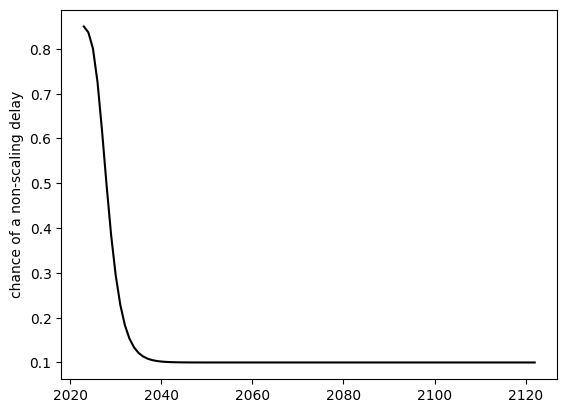

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 85%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 84%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 80%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 73%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 62%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 38%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2033

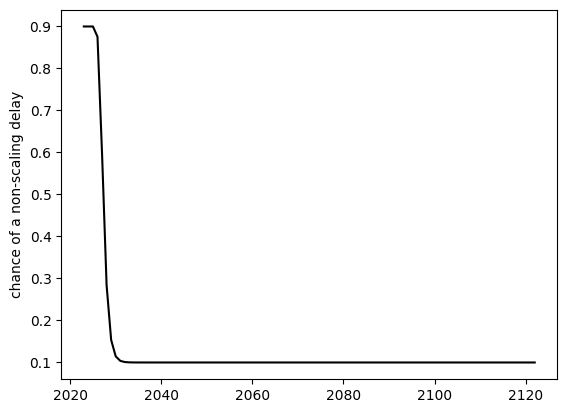

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 88%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 28%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 15%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

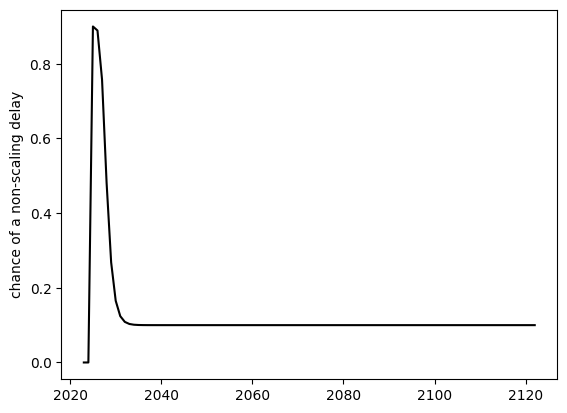

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 0%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 90%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 89%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 76%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 48%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 17%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 11%
Year: 2033 -

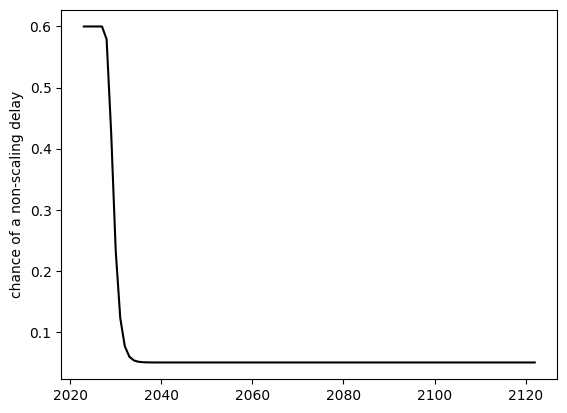

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 58%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 43%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 8%
Year: 2033 

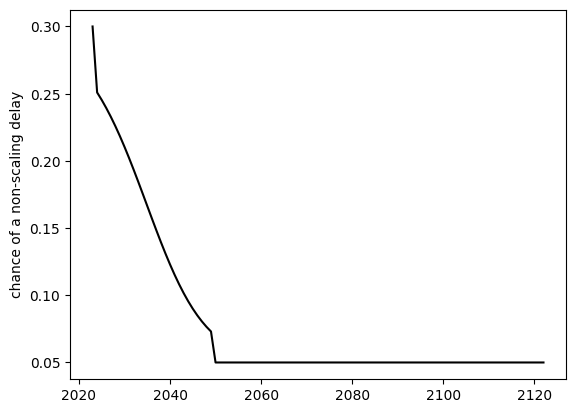

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 25%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 24%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 23%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 21%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2033

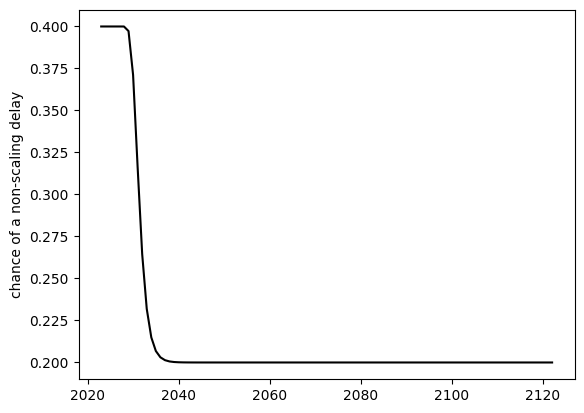

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 40%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 26%
Year: 2033

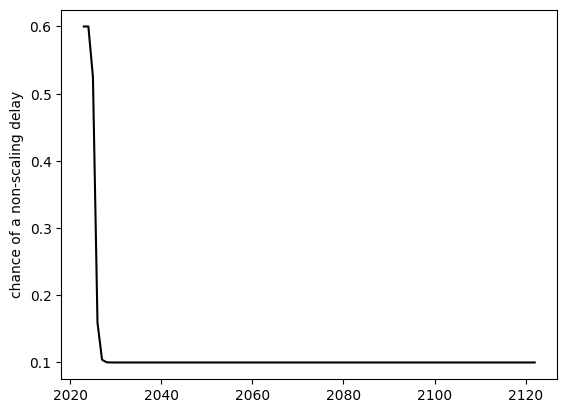

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 52%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 16%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

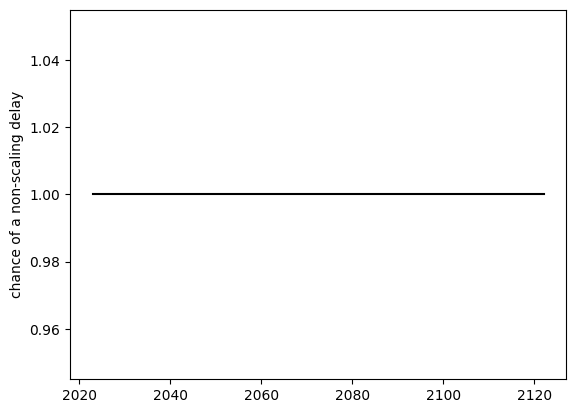

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 100%


/Users/peterhurford/.virtualenvs/dev/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/peterhurford/.virtualenvs/dev/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: cannot convert float NaN to integer

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


In [ ]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(variables, verbose=True)